<a href="https://colab.research.google.com/github/XieN-N/Human-or-Horse-model/blob/main/BERT_%2B_Recurrent_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import re
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
tqdm.pandas()

In [ ]:
data_train = pd.read_csv('Dataset/train.csv')
data_test = pd.read_csv('Dataset/test.csv')
sample_submission = pd.read_csv('Dataset/sample_submission.csv')
print(data_train.head())
print(data_test.head())
sample_submission.head()

         oid      category                                               text
0  365271984  winter_sport  Волшебные фото Виктория Поплавская ЕвгенияМедв...
1  503385563       extreme  Возвращение в подземелье Треша 33 Эйфория тупо...
2  146016084      football  Лучшие чешские вратари – Доминик Доминатор Гаш...
3  933865449    boardgames  Rtokenoid Warhammer40k валрак решил нас подкор...
4  713550145        hockey  Шестеркин затаскивает Рейнджерс в финал Восточ...
         oid                                               text
0  749208109  СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...
1  452466036  Естественное восстановление после тяжелой трен...
2  161038103  Тема нарядов продолжается Одна из британских ж...
3  663621910  Привет Избранный. Ты спрашиваешь себя ЧТО здес...
4  566255305  КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...


,oid,category
0,1622114,athletics
1,1663817,autosport
2,3174332,basketball
3,3469228,extreme
4,3905302,boardgames


Удаление дубликатов и строк с пропущенными значениями:

In [ ]:
# Удаляем дубликаты:

data_train = pd.DataFrame.drop_duplicates(data_train)
data_test = pd.DataFrame.drop_duplicates(data_test)

# Удаляем строки, в которых есть NAN значения:

data_train = pd.DataFrame.dropna(data_train)
data_test = pd.DataFrame.dropna(data_test)

In [ ]:
dict_oid_to_category = dict(zip(sample_submission.oid, sample_submission.category))

In [ ]:
dict_oid_to_category[3174332]

'basketball'

In [ ]:
def oid_to_category(oid):
    return dict_oid_to_category[oid]

In [ ]:
data_test['category'] = data_test['oid'].progress_apply(oid_to_category)

100%|████████████████████████████████| 26049/26049 [00:00<00:00, 1892952.37it/s]


In [ ]:
data_test.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,452466036,Естественное восстановление после тяжелой трен...,martial_arts
2,161038103,Тема нарядов продолжается Одна из британских ж...,tennis
3,663621910,Привет Избранный. Ты спрашиваешь себя ЧТО здес...,esport
4,566255305,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...,tennis


In [ ]:
categories = data_train['category'].unique()

dict_to_cat = {c: i for i, c in enumerate(categories)}
cat_to_dict = {i: c for i, c in enumerate(categories)}

def transform_label(label, label_to_cat=False):

    vector_shape = len(categories)
    one_hot_vector = np.zeros((vector_shape,))
    one_hot_vector[dict_to_cat[label]] = 1

    if label_to_cat:
        return torch.from_numpy(one_hot_vector)
    else:
        return dict_to_cat[label]

In [ ]:
data_train['label'] = data_train['category'].progress_apply(transform_label)
data_test['label'] = data_test['category'].progress_apply(transform_label)

100%|█████████████████████████████████| 26049/26049 [00:00<00:00, 981295.36it/s]


In [ ]:
print(data_train['label'].unique())
data_train.head()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


,oid,category,text,label
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,0
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,1
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,2
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,4


In [ ]:
print(data_test['label'].unique())
data_test.head()

[ 5 11  9  8 10 12  3  6  0  4  2  7  1]


,oid,text,category,label
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,5
1,452466036,Естественное восстановление после тяжелой трен...,martial_arts,11
2,161038103,Тема нарядов продолжается Одна из британских ж...,tennis,9
3,663621910,Привет Избранный. Ты спрашиваешь себя ЧТО здес...,esport,5
4,566255305,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...,tennis,9


Видим, что текста каждого класса примерно одинаковое количество, нет нужды учитывать веса классов (они все примерно равны 1):

In [ ]:
data_train.category.value_counts(normalize=True) # распределение практически одинаковое

category
autosport       0.081913
extreme         0.079955
motosport       0.078885
martial_arts    0.078546
tennis          0.078258
boardgames      0.077527
athletics       0.077214
hockey          0.076770
volleyball      0.076614
esport          0.076431
football        0.074212
winter_sport    0.072933
basketball      0.070741
Name: proportion, dtype: float64

In [ ]:
data_train['token_length'] = data_train.text.progress_apply(lambda x: len(x.split()))
data_test['token_length'] = data_test.text.progress_apply(lambda x: len(x.split()))

100%|█████████████████████████████████| 26049/26049 [00:00<00:00, 264517.00it/s]


In [ ]:
for i in range(len(data_train['label'].unique())):
    data_pos = data_train[data_train['label'] == i]
    print(f'{i} класс')
    print(data_pos['token_length'].describe())
    print('--------------')

0 класс
count    2794.000000
mean       69.301718
std        79.481921
min         3.000000
25%        14.000000
50%        39.000000
75%        95.000000
max       492.000000
Name: token_length, dtype: float64
--------------
1 класс
count    3063.000000
mean       67.602351
std        72.996469
min         6.000000
25%        19.000000
50%        43.000000
75%        87.000000
max       503.000000
Name: token_length, dtype: float64
--------------
2 класс
count    2843.000000
mean       46.775237
std        62.972474
min         5.000000
25%        13.000000
50%        23.000000
75%        50.000000
max       474.000000
Name: token_length, dtype: float64
--------------
3 класс
count    2970.000000
mean       64.240741
std        52.068765
min         7.000000
25%        29.000000
50%        53.000000
75%        82.000000
max       445.000000
Name: token_length, dtype: float64
--------------
4 класс
count    2941.000000
mean       59.057123
std        73.490914
min         5.000000
25% 

<Axes: >

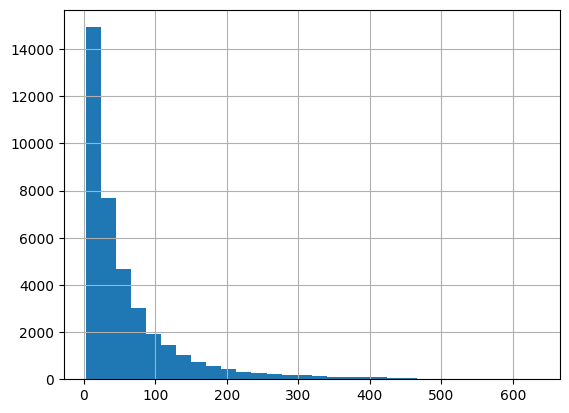

In [ ]:
seq_len = [len(i.split()) for i in data_train['text']]

pd.Series(seq_len).hist(bins = 30)

Анализируя данные тексты, можно сказать, что можно обрезать все тексты до 80 символов.

In [ ]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)
    s = re.sub(r'\s{2,}', ' ', s)
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

In [ ]:
def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_emoji = rm_emoji(no_whitespaces)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [ ]:
data_train['clean'] = data_train['text'].progress_apply(clean_pipeline)
data_test['clean'] = data_test['text'].progress_apply(clean_pipeline)
data_train.head()

100%|██████████████████████████████████| 26049/26049 [00:01<00:00, 18766.52it/s]


,oid,category,text,label,token_length,clean
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,0,6,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,1,43,Возвращение в подземелье Треша Эйфория тупости...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,2,110,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3,209,Rtokenoid Warhammerk валрак решил нас подкорми...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,4,382,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [ ]:
data_test.head()

,oid,text,category,label,token_length,clean
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,5,16,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА Р ЗА ПОКУПКОЙ П...
1,452466036,Естественное восстановление после тяжелой трен...,martial_arts,11,67,Естественное восстановление после тяжелой трен...
2,161038103,Тема нарядов продолжается Одна из британских ж...,tennis,9,33,Тема нарядов продолжается Одна из британских ж...
3,663621910,Привет Избранный. Ты спрашиваешь себя ЧТО здес...,esport,5,102,Привет Избранный . Ты спрашиваешь себя ЧТО зде...
4,566255305,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...,tennis,9,26,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...


In [ ]:
data_train[['clean', 'label']].to_csv('./train_clean.csv', index=False, header=True)
data_test[['clean', 'label']].to_csv('./test_clean.csv', index=False, header=True)

Загружаем предобработанные данные:

In [ ]:
data_train = pd.read_csv('./train_clean.csv')
data_test = pd.read_csv('./test_clean.csv')

for row in data_train[:3].iterrows():
    print(row[1]['clean'])
    print(f'Label: {row[1]["label"]}')
    print('\n')

Волшебные фото Виктория Поплавская ЕвгенияМедведева Evgentokenoid
Label: 0


Возвращение в подземелье Треша Эйфория тупости и жадности зашкаливает В этот раз мы посетим Ростовскую область . Всю . И знаете это пока что единственный выпуск в котором не будет . . . А впрочем сами все увидите Ссылка на видео в источнике
Label: 1


Лучшие чешские вратари – Доминик Доминатор Гашек и Петр Танкист Чех . Примечательно что в детстве Чех мечтал стать хоккеистом а его кумиром был никто иной как Доминик Гашек . Однако стать звездой НХЛ Чеху было не суждено . Петр родился в небогатой семье денег едва хватало на базовые расходы а хоккейная экипировка оказалась не по карману его родителям . А вот футбольные принадлежности родители могли купить без проблем поэтому Петр и выбрал данный вид спорта . Чех хоть и был очень огорчен но решил что однажды обязательно будет играть в хоккей . И его мечта сбылась . Уже после завершения футбольной карьеры он подписал контракт с английской командой Гилфорд Феникс вы

In [ ]:
train_text = data_train['clean']
train_labels = data_train['label']
test_text = data_test['clean']
test_labels = data_test['label']

In [ ]:
train_text, train_labels = sklearn.utils.shuffle(train_text, train_labels)

In [ ]:
test_text, val_text, test_labels, val_labels = train_test_split(test_text, test_labels, test_size=0.3)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

/home/xxienn/.pytorch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
text = ["Проверка БЕРТ", "Прогноз погоды"]

sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

print(sent_id)

{'input_ids': [[101, 1194, 16856, 19259, 15290, 16856, 28598, 1181, 15290, 16856, 22919, 102, 0, 0, 0], [101, 1194, 16856, 14150, 29741, 18947, 14150, 29744, 1194, 14150, 29741, 14150, 29742, 29113, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
max_seq_len = 80

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/xxienn/.pytorch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

batch_size = 128

train_data = TensorDataset(train_seq,
                           train_mask,
                           train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data,
                            sampler = val_sampler,
                            batch_size = batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        self.bert = bert_model # используем языковую модель для получения эмбеддингов текста
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_size, batch_first=True) # будем передавать на LSTM
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        lstm_output, (hidden, cell) = self.lstm(last_hidden_state)

        hidden = hidden[-1]

        hidden = self.dropout(hidden)

        logits = self.fc(hidden)

        #probs = self.softmax(logits)

        return logits

In [ ]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [ ]:
hidden_size = 128
num_classes = len(data_train['label'].unique())
print(num_classes)

model = TextClassifier(bert, hidden_size, num_classes)
model = model.to(device)

13


In [ ]:
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    total_preds=[]

    len_td = len(train_dataloader)

    for step, batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:

            print(' Batch {:>5,} of {:>5,}.'.format(step, len_td))

        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        model.zero_grad()

        preds = model(sent_id, mask)

        loss = criterion(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    avg_loss = total_loss / len_td

    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Определение функции оценки
def evaluate():

    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0

    total_preds=[]
    len_vd = len(val_dataloader)
    for step, batch in enumerate(val_dataloader):

        if step % 50 == 0 and not step == 0:

            print(' Batch {:>5,} of {:>5,}.'.format(step, len_vd))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():

            preds = model(sent_id, mask)
            loss = criterion(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    avg_loss = total_loss / len_vd
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 5

Очистка памяти, используем только тогда, когда необходимо:

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

Обучаем модель:

In [ ]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()

    valid_loss, val_pred = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_rnn_with_MORE_EPOCHS_10.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
 Batch    50 of   300.
 Batch   100 of   300.
 Batch   150 of   300.
 Batch   200 of   300.
 Batch   250 of   300.

Evaluating...
 Batch    50 of    62.

Training Loss: 1.556
Validation Loss: 1.499

 Epoch 2 / 5
 Batch    50 of   300.
 Batch   100 of   300.
 Batch   150 of   300.
 Batch   200 of   300.
 Batch   250 of   300.

Evaluating...
 Batch    50 of    62.

Training Loss: 1.468
Validation Loss: 1.427

 Epoch 3 / 5
 Batch    50 of   300.
 Batch   100 of   300.
 Batch   150 of   300.
 Batch   200 of   300.
 Batch   250 of   300.

Evaluating...
 Batch    50 of    62.

Training Loss: 1.389
Validation Loss: 1.406

 Epoch 4 / 5
 Batch    50 of   300.
 Batch   100 of   300.
 Batch   150 of   300.
 Batch   200 of   300.
 Batch   250 of   300.

Evaluating...
 Batch    50 of    62.

Training Loss: 1.327
Validation Loss: 1.338

 Epoch 5 / 5
 Batch    50 of   300.
 Batch   100 of   300.
 Batch   150 of   300.
 Batch   200 of   300.
 Batch   250 of   300.

Evaluating...
 Batch  

После обучения (5 + 5 эпох) посмотрим на результаты:

In [ ]:
batch_size_for_test = 256
with torch.no_grad():
    for i in range(int(test_seq.shape[0]/batch_size_for_test)):
        preds = model(test_seq[i*batch_size_for_test:i*batch_size_for_test+batch_size_for_test].to(device), test_mask[i*batch_size_for_test:i*batch_size_for_test+batch_size_for_test].to(device))
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis = 1)
        if i == 0:
            all_preds = preds
        else:
            all_preds = np.append(all_preds, preds)
        if i == 30:
            break

print(classification_report(torch.Tensor.numpy(test_y[:all_preds.shape[0]]), all_preds))

              precision    recall  f1-score   support

           0       0.60      0.54      0.57       669
           1       0.32      0.48      0.39       606
           2       0.46      0.36      0.40       546
           3       0.63      0.74      0.68       617
           4       0.63      0.53      0.57       640
           5       0.63      0.57      0.60       606
           6       0.66      0.70      0.68       722
           7       0.70      0.78      0.74       624
           8       0.75      0.57      0.65       560
           9       0.89      0.72      0.80       591
          10       0.65      0.57      0.61       563
          11       0.55      0.47      0.50       518
          12       0.51      0.69      0.59       674

    accuracy                           0.60      7936
   macro avg       0.61      0.59      0.60      7936
weighted avg       0.61      0.60      0.60      7936



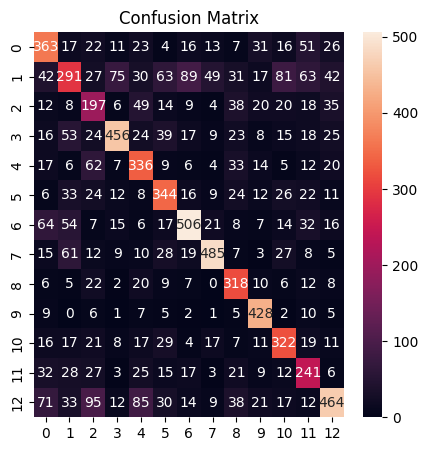

In [ ]:
cm = confusion_matrix(all_preds, torch.Tensor.numpy(test_y[:all_preds.shape[0]]))
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()